In [1]:
from megs.model.mPCA import mPCA
from megs.data import image, Gamma, Galaxy

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

import numpy as np
import pickle
from tqdm import trange
import seaborn as sns
sns.set_context("paper", font_scale=1.5)

In [2]:
data = Gamma("/export/data/ucakir/final_gamma_data/gamma_backup.hdf5")

File: /export/data/ucakir/final_gamma_data/galaxy_data.hdf5
Group: Galaxies
    Group: Attributes
        Dataset: halo_id (float32) ((11727,))
        Dataset: mass (float32) ((11727,))
    Group: ImageAttributes
        Group: GFM_Metallicity
            Dataset: max (float32) ((11727,))
            Dataset: min (float32) ((11727,))
        Group: GFM_StellarFormationTime
            Dataset: max (float32) ((11727,))
            Dataset: min (float32) ((11727,))
        Group: Masses
            Dataset: max (float32) ((11727,))
            Dataset: min (float32) ((11727,))
    Group: Particles
        Group: stars
            Group: Images
                Group: dim2
                    Dataset: GFM_Metallicity (float32) ((11727, 64, 64))
                    Dataset: GFM_StellarFormationTime (float32) ((11727, 64, 64))
                    Dataset: Masses (float32) ((11727, 64, 64))
                Group: dim3
                    Dataset: GFM_Metallicity (float32) ((11727, 64, 64, 64

In [5]:
gammaid = np.load("/export/home/ucakir/MEGS/MEGS/src/megs/gamma_ids.npy")
gammaid.shape

(11975,)

In [4]:
ids = data.get_attribute("halo_id")
ids.shape

(12484,)

In [7]:
mask = np.isin(ids, gammaid)

In [9]:
print("number of galaxies in data: ", len(ids))
print("Gamma galaxies: ", len(gammaid))
print("Number of galaxies: ", len(ids[mask]))

number of galaxies in data:  12484
Gamma galaxies:  11975
Number of galaxies:  11924


In [8]:
n = 0
not_in_gammaid = []
for index in ids:
    if index in gammaid:
       continue
    else:
        not_in_gammaid.append(index)
        n += 1
        

print("total number of galaxies in ids:", len(ids))
print("total number of galaxies in gammaid:", len(gammaid))
print("total number", n)

total number of galaxies in ids: 12484
total number of galaxies in gammaid: 11975
total number of galaxies in both: 560


In [11]:
# number of galaxies that are in gammaid but not in ids
num = np.sum(np.isin(ids, gammaid, invert=True))
print(num)

560


In [3]:
norm = image.norm # Normalization function
lower = 0.25
upper = 1.0
norm_function_args = {"Masses": {"takelog": True, "plusone": True,"lower": lower, "upper": upper},
                     "GFM_Metallicity": {"takelog": True, "plusone": True, "lower": 0.25, "upper": upper},
                     "GFM_StellarFormationTime": {"takelog": True, "plusone": True, "lower": 0.25, "upper": upper},
}

In [4]:
mm = mPCA(data, norm_function = norm, norm_function_kwargs=norm_function_args, dim = 2)

Creating datamatrix with the following fields:
Particle type:  stars
Fields:  ['GFM_Metallicity', 'GFM_StellarFormationTime', 'Masses']
Dimension:  dim2
Default arguments are used for the fields that are not specified in the norm_function_kwargs
Created datamatrix with shape:  (11727, 12288)


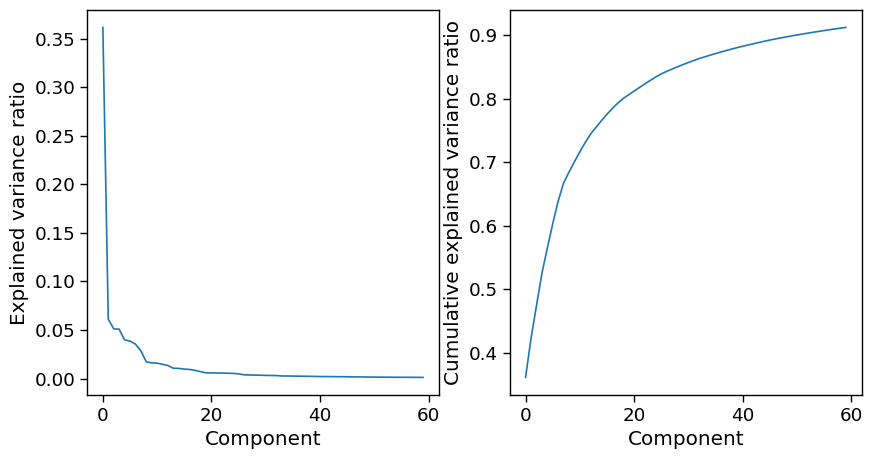

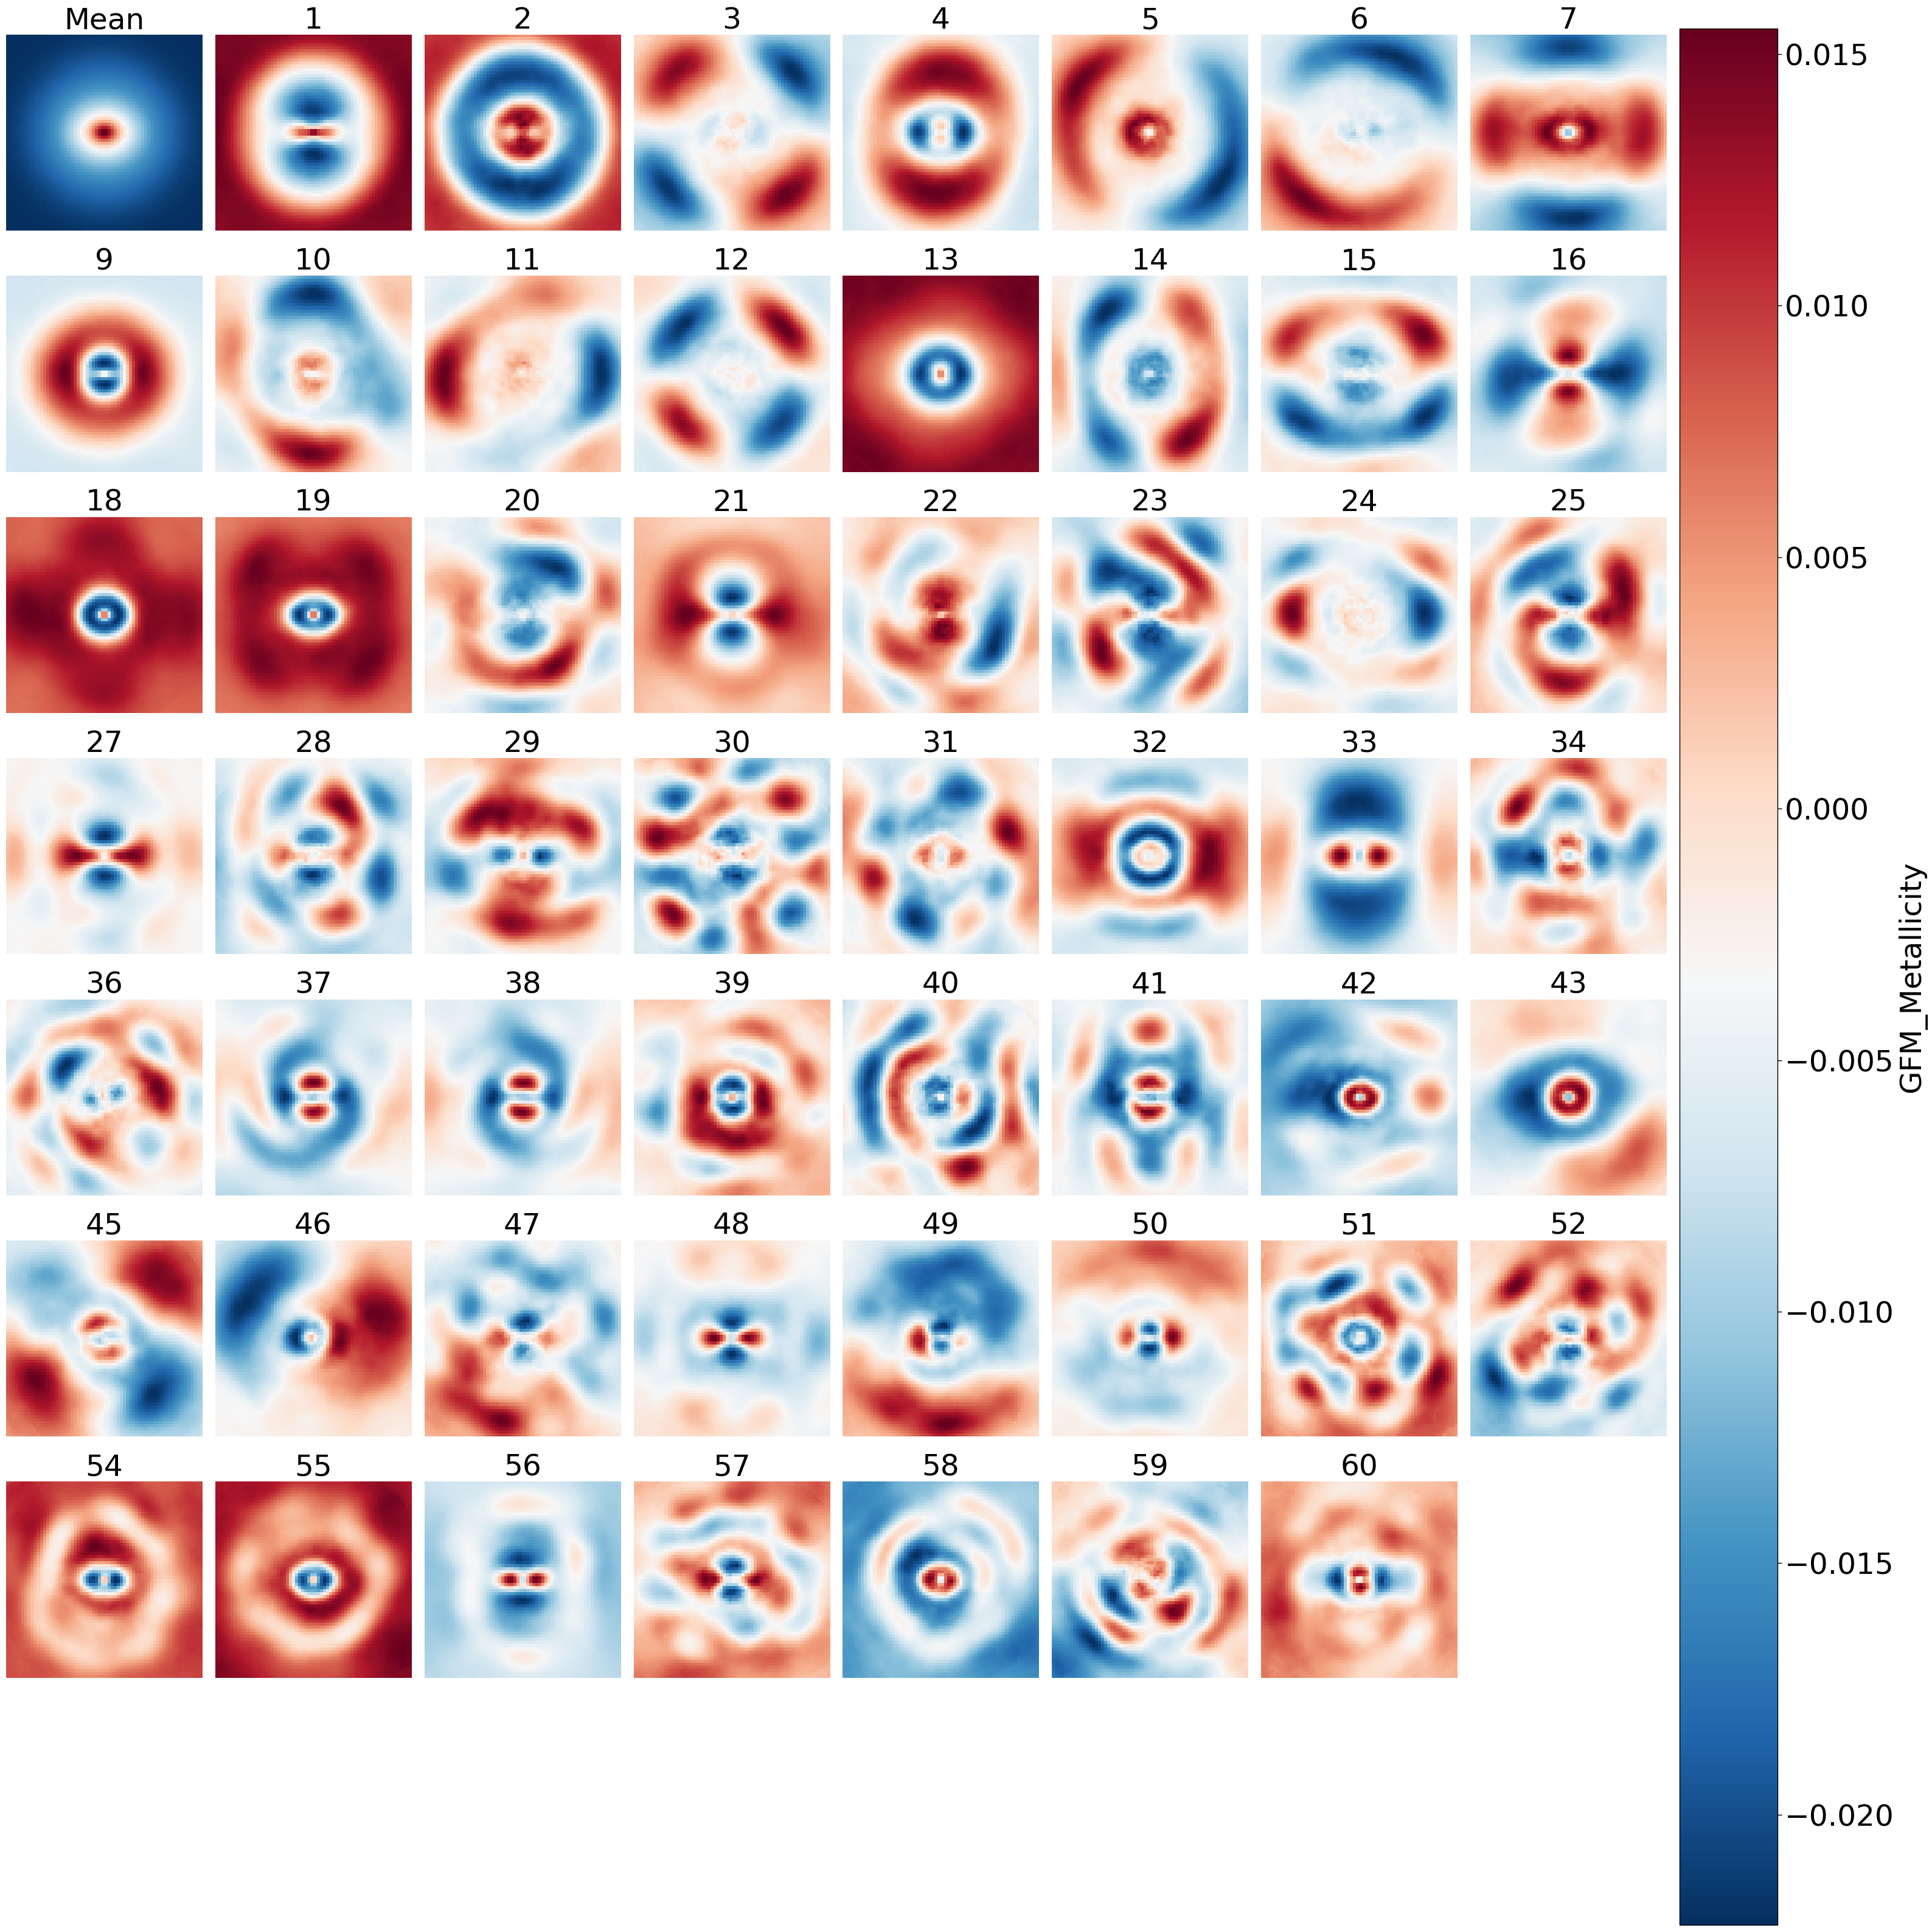

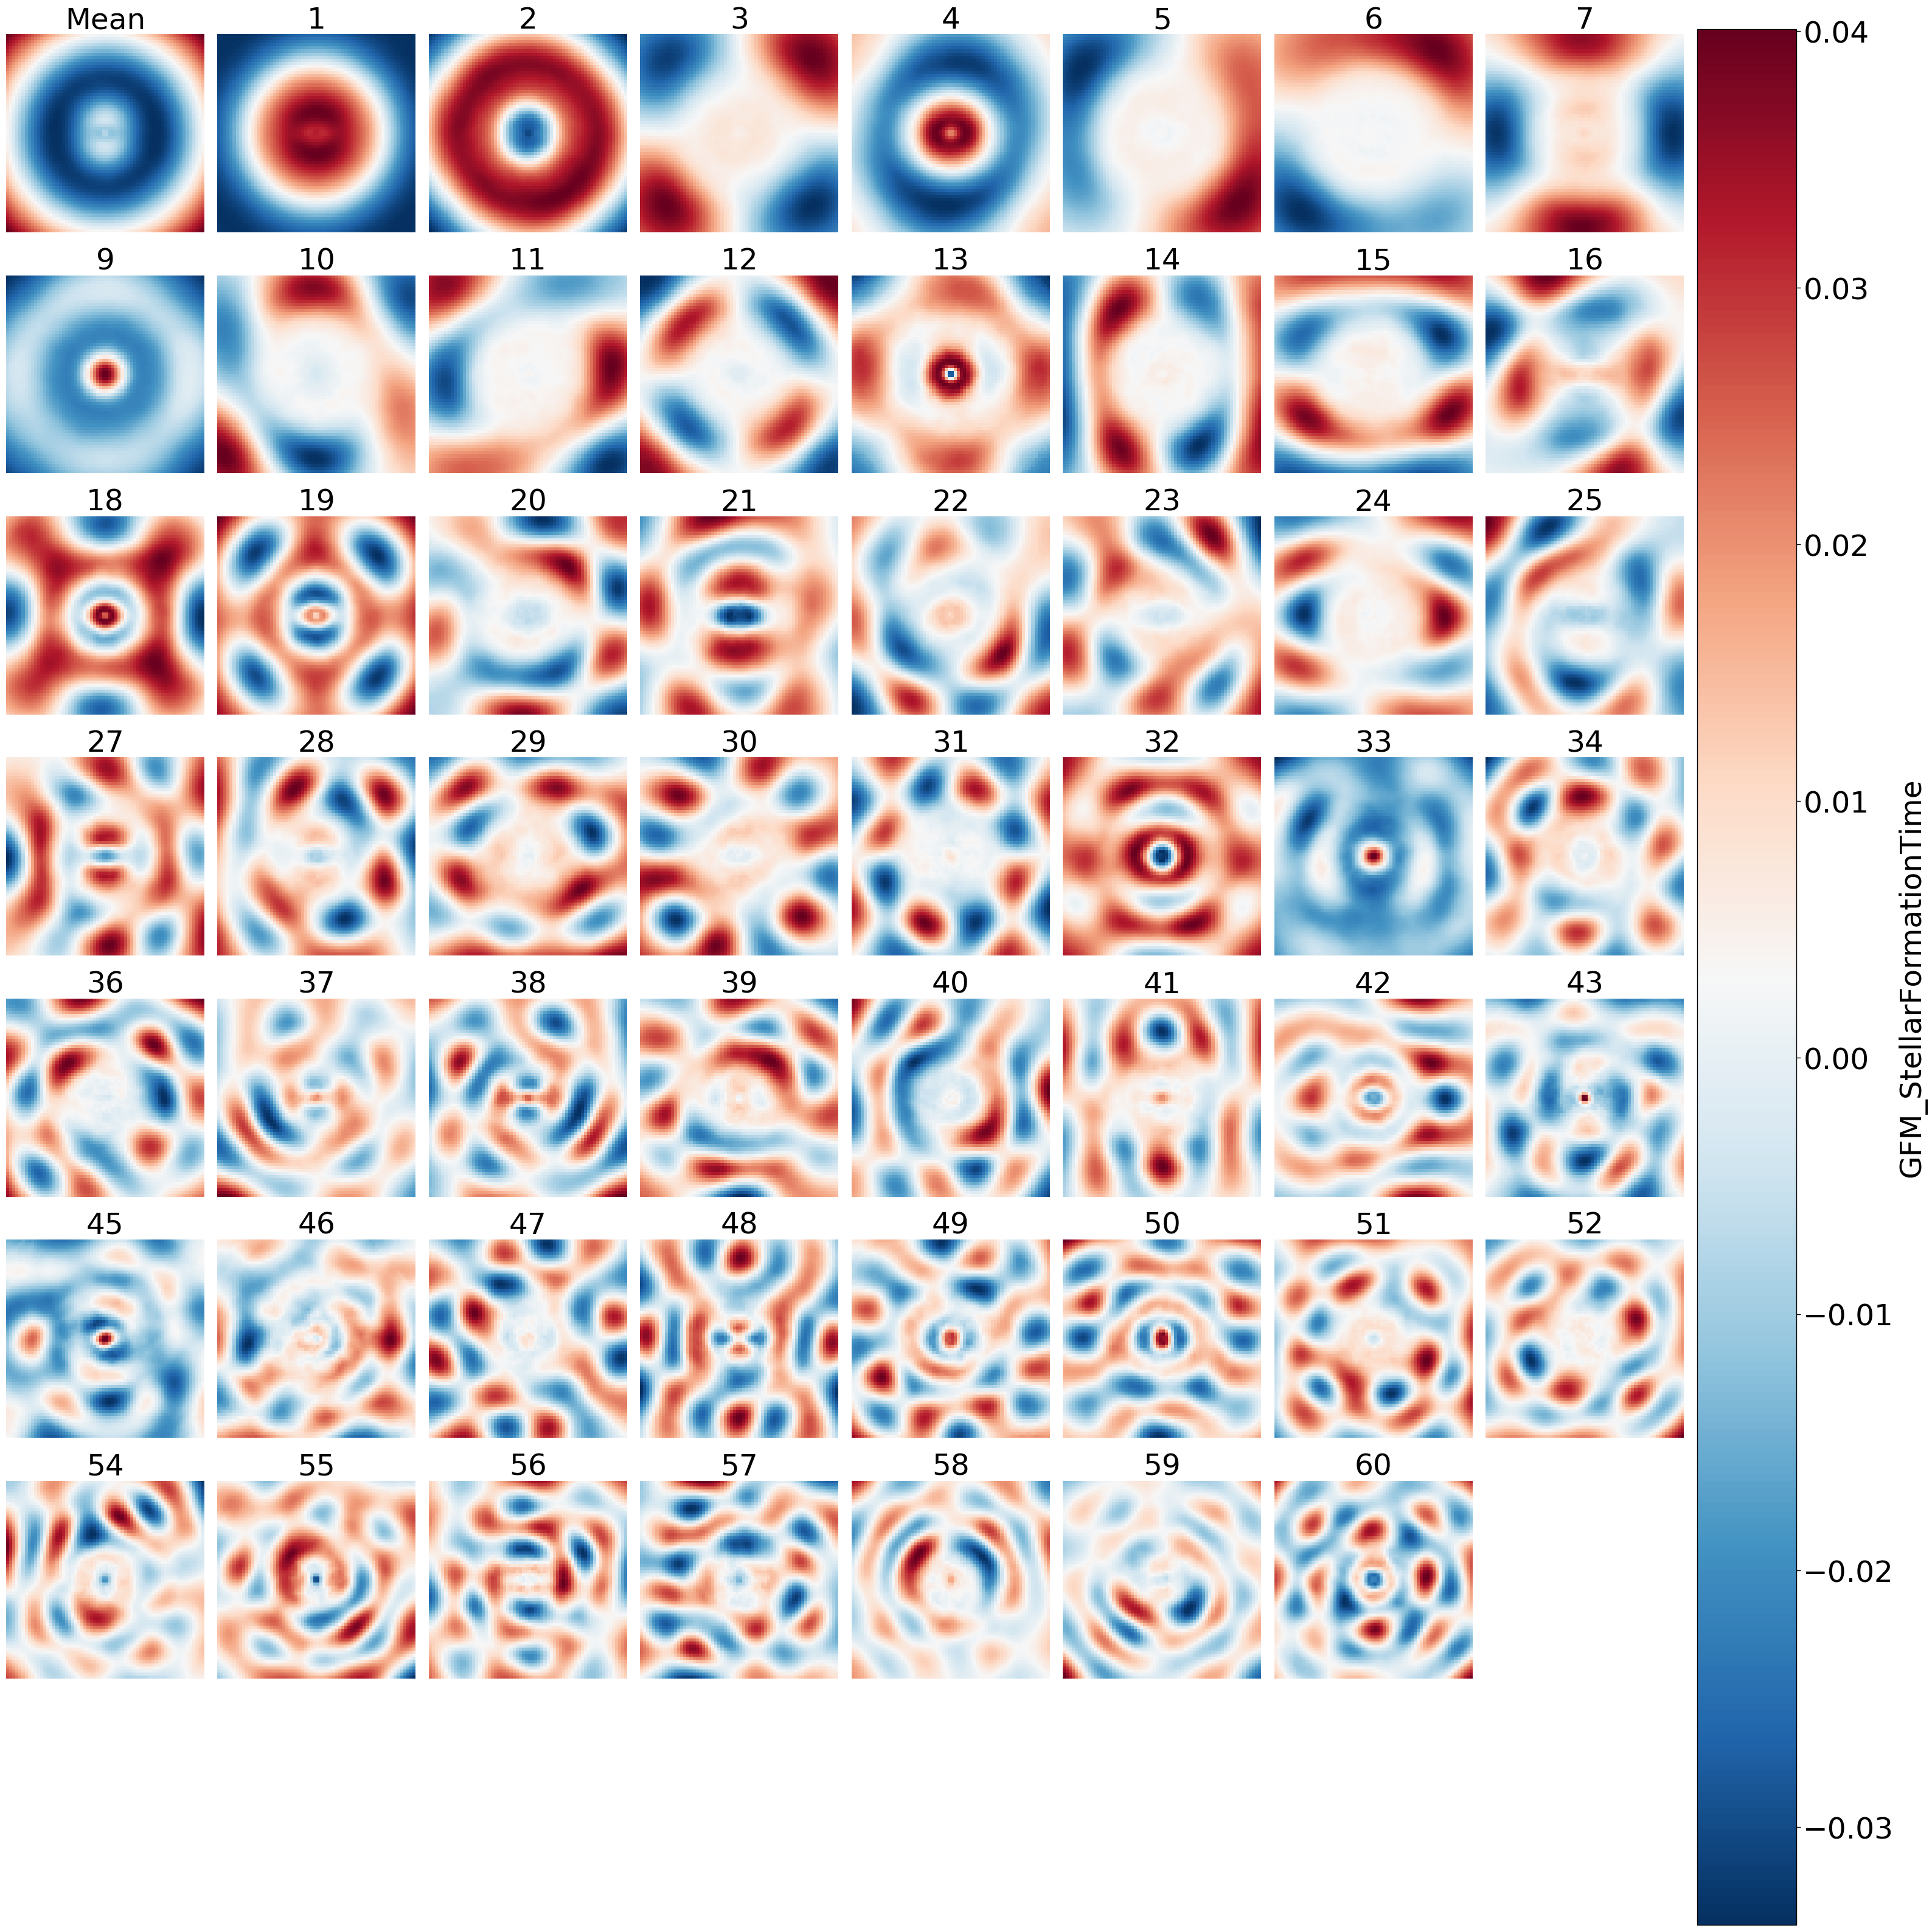

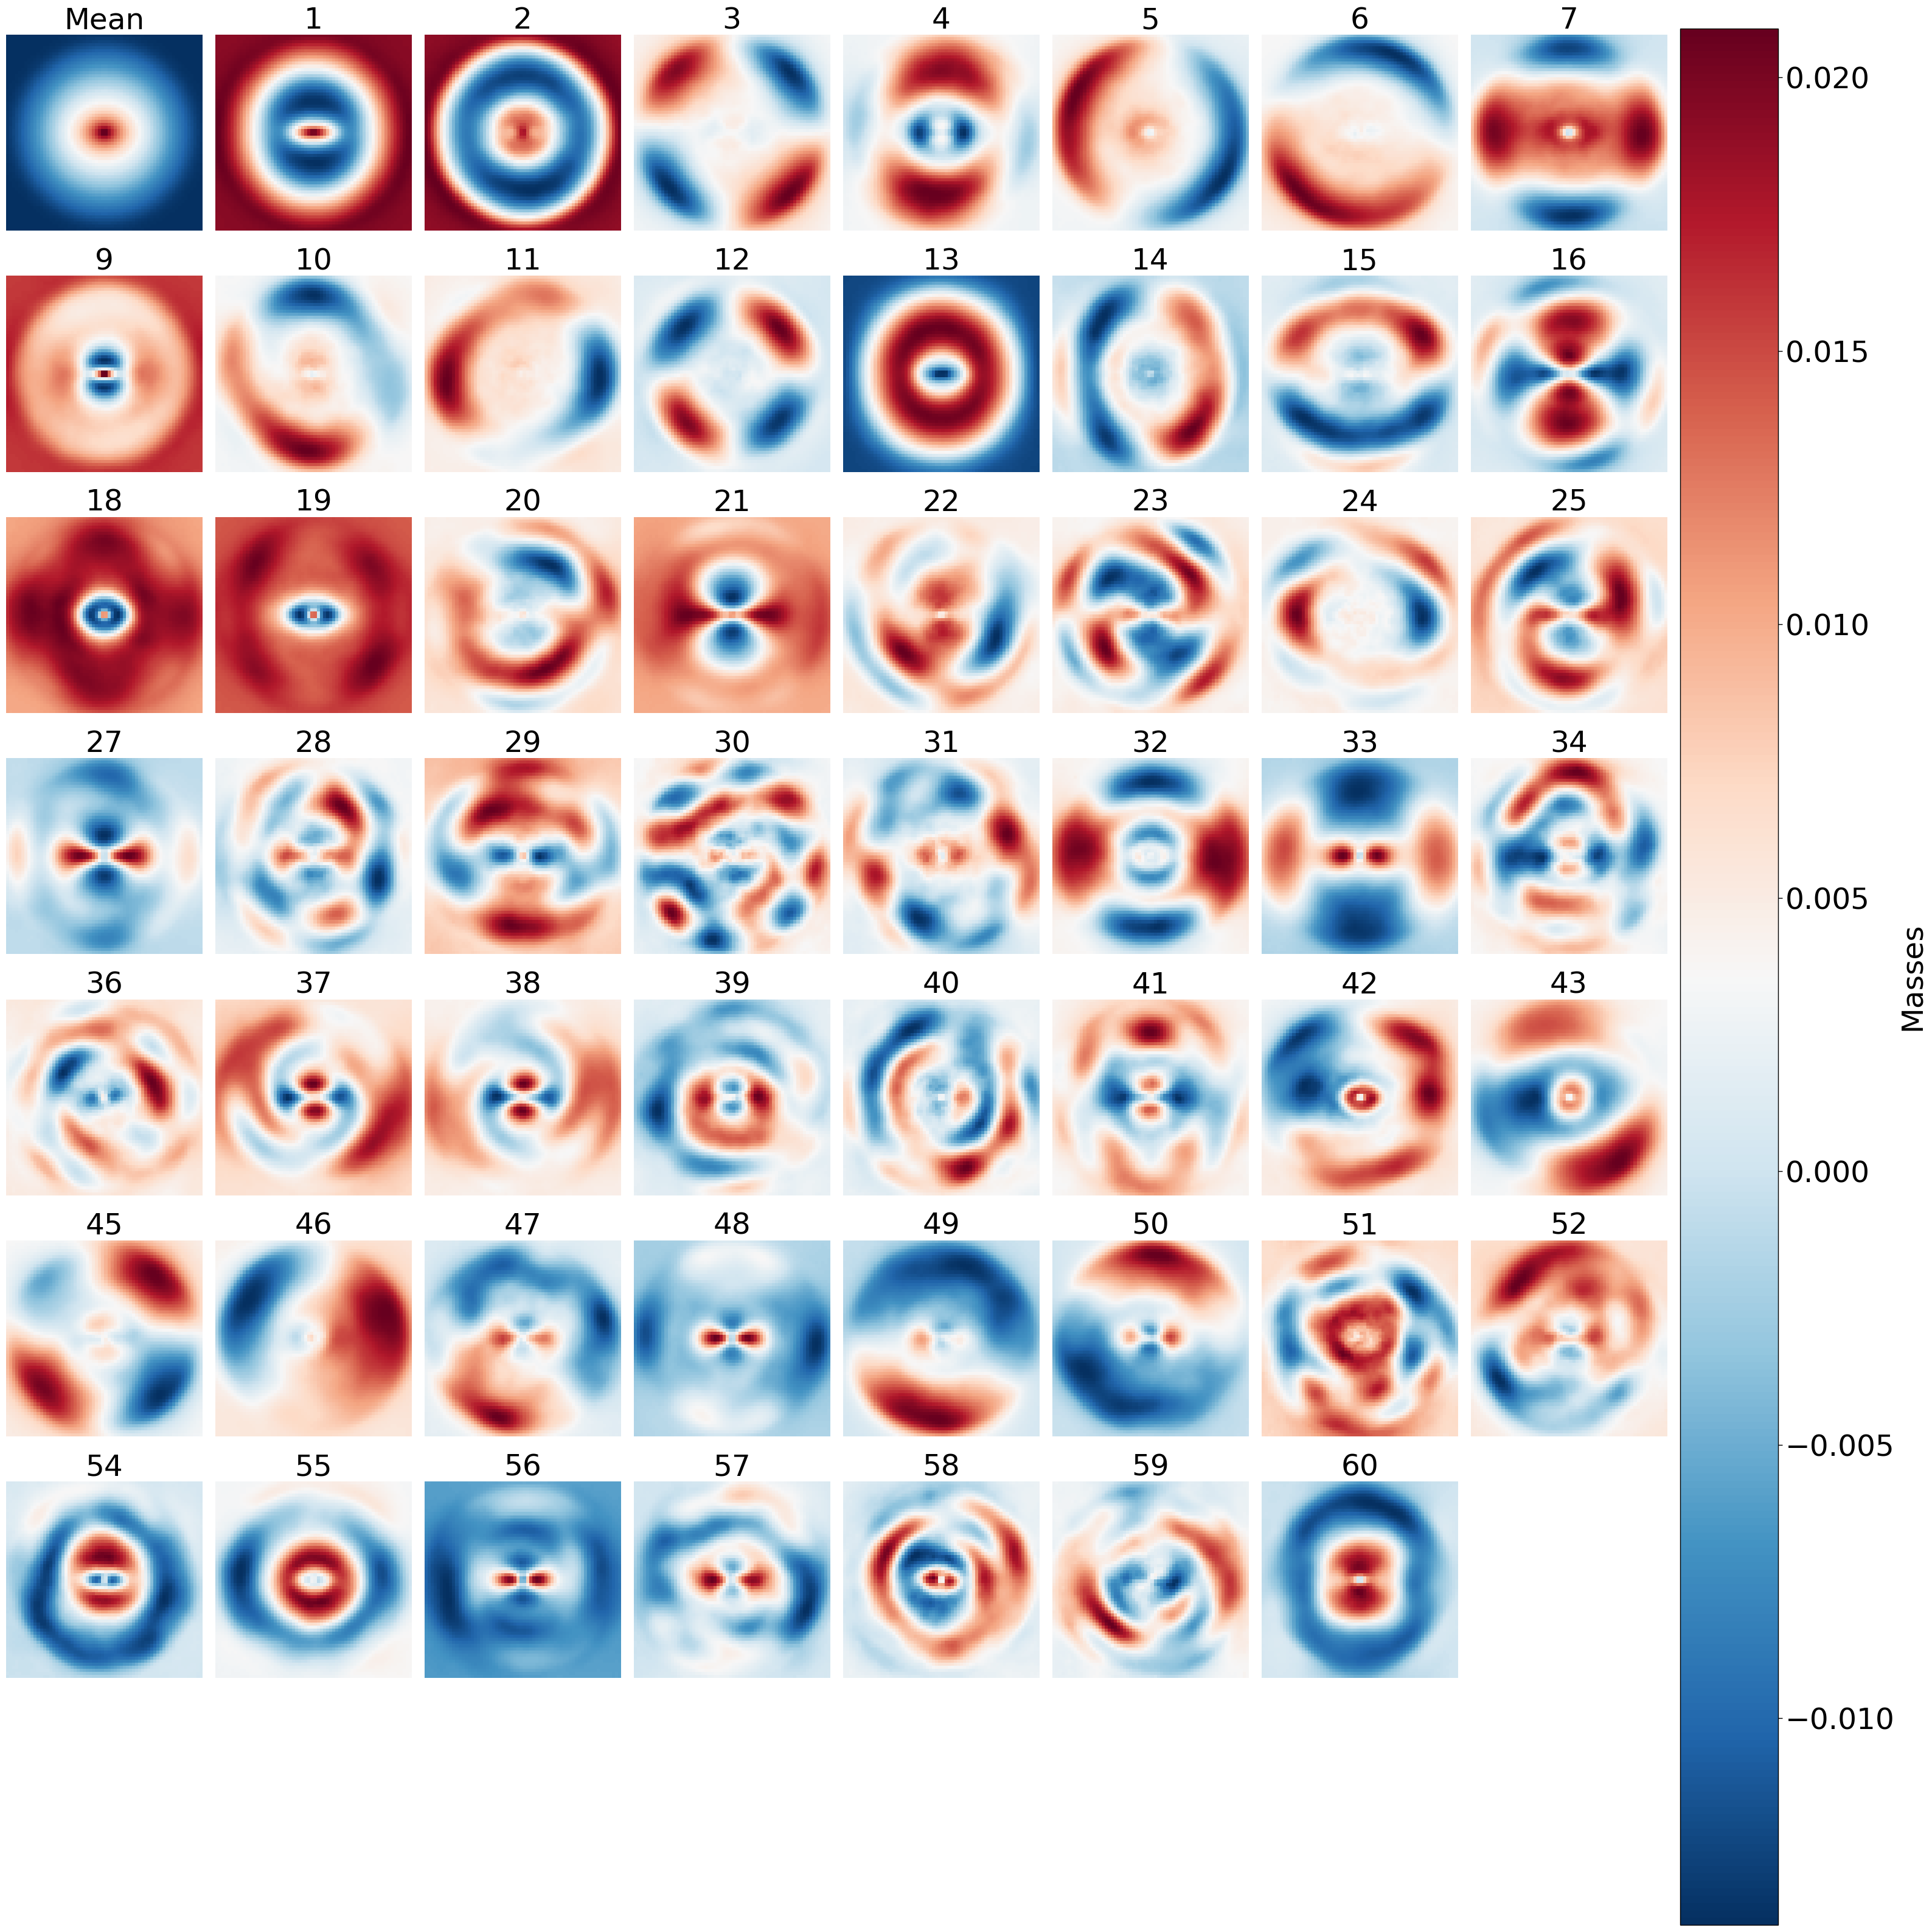

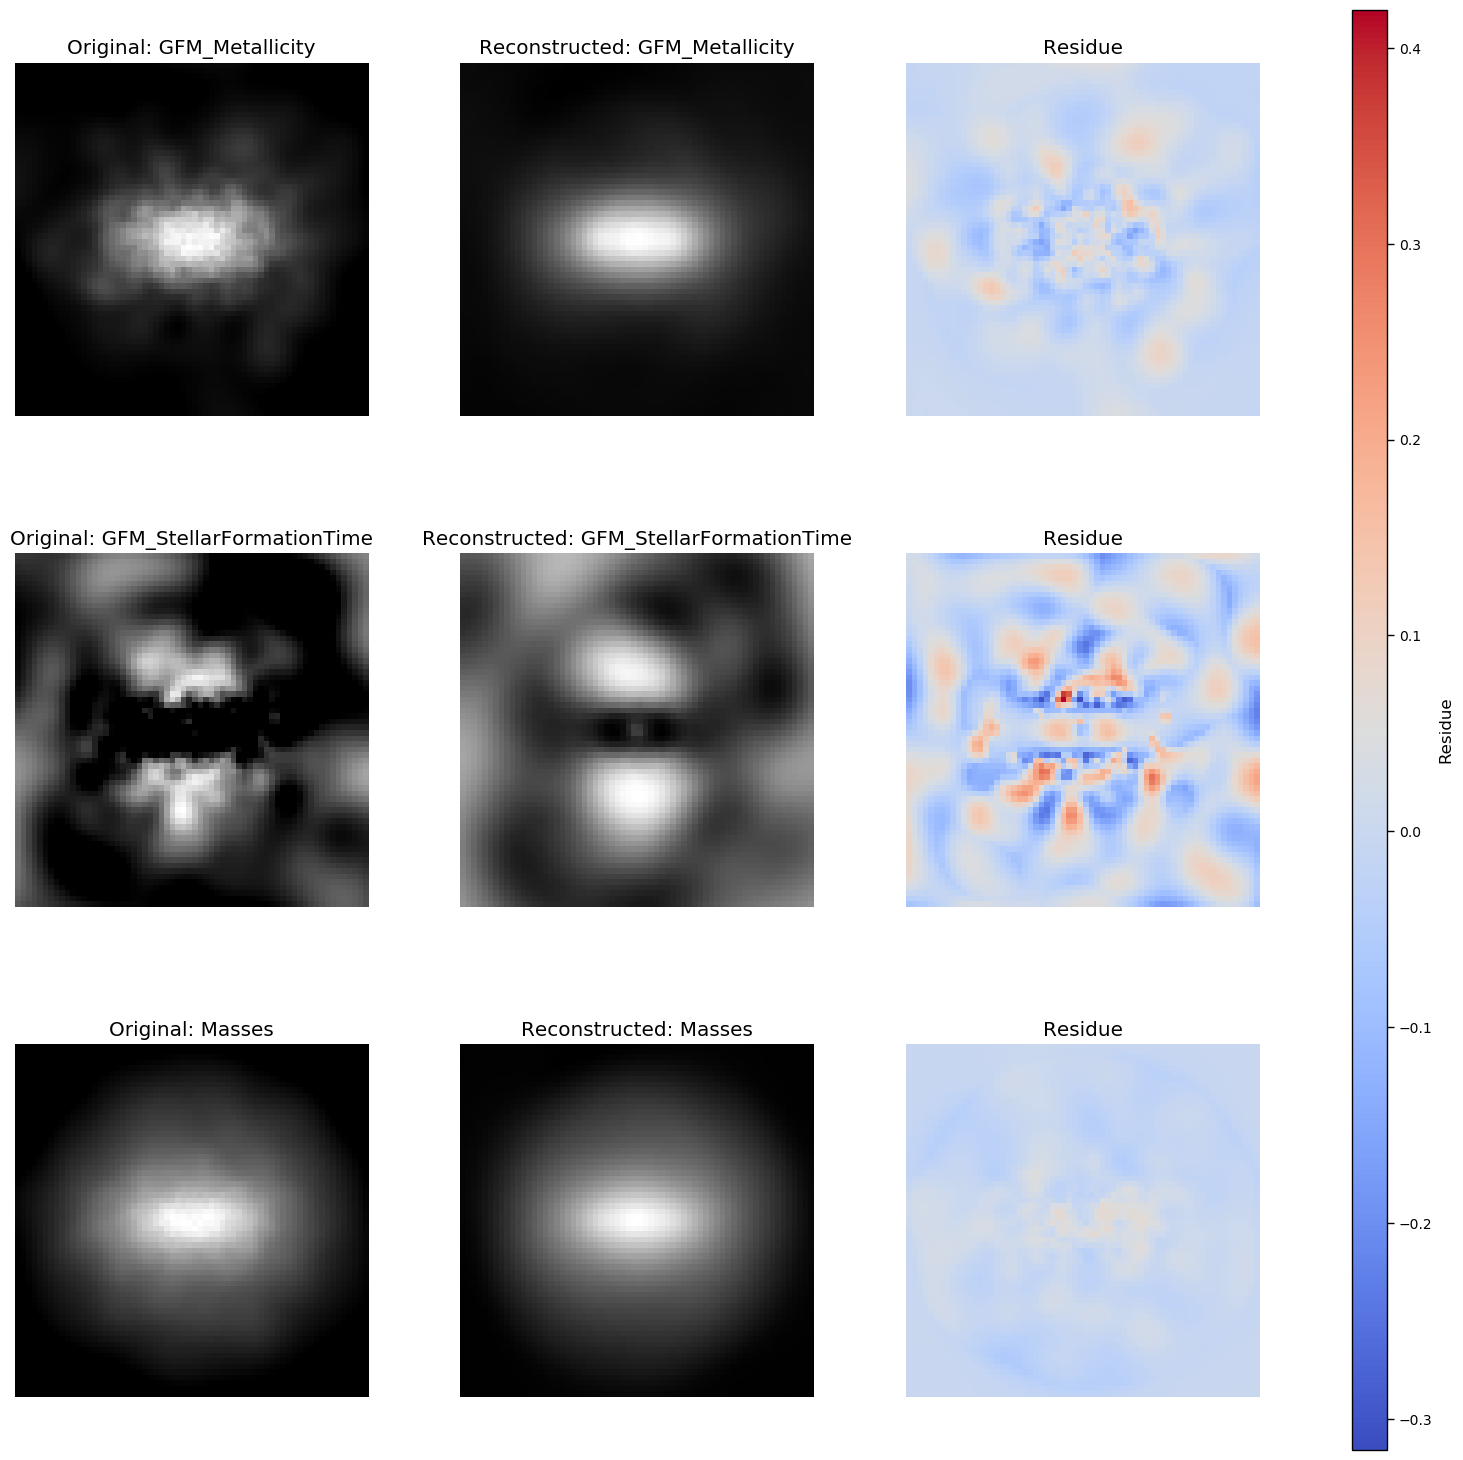

In [5]:
mm.fit(n_components = 60,show_results = True)

In [6]:
mm.pca.explained_variance_ratio_.sum()

0.9118976081673212

In [ ]:
mm.pca.explained_variance_ratio_.sum()

0.9084219435174086

In [7]:
# Get likelihoods
likelihood = mm.pca.score_samples(mm.datamatrix)

In [22]:
images = mm.datamatrix.reshape(-1,3, 64, 64)[:,0]

In [54]:
def make_frame(img, indent):
    # clip the image and invert to only get outer regions
    left = img[:, :indent]
    right = img[:, -indent:]
    top = img[:indent, :]
    bottom = img[-indent:, :]
    array = left.tolist() + right.tolist() + top.tolist() + bottom.tolist()
    return np.array(array)

In [9]:
indx = np.argsort(likelihood)

# Get least likely galaxies 
low_likelihood = mm.datamatrix[indx[:25]].reshape(-1, 3, 64,64)

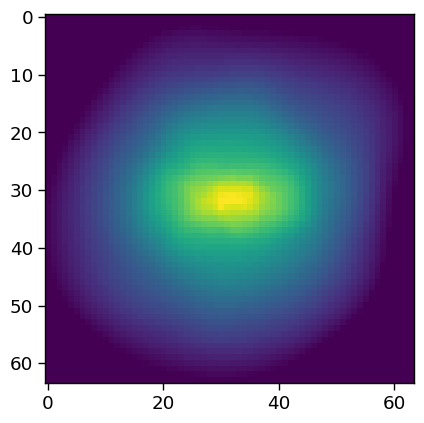

In [25]:
plt.imshow(low_likelihood[9][2])

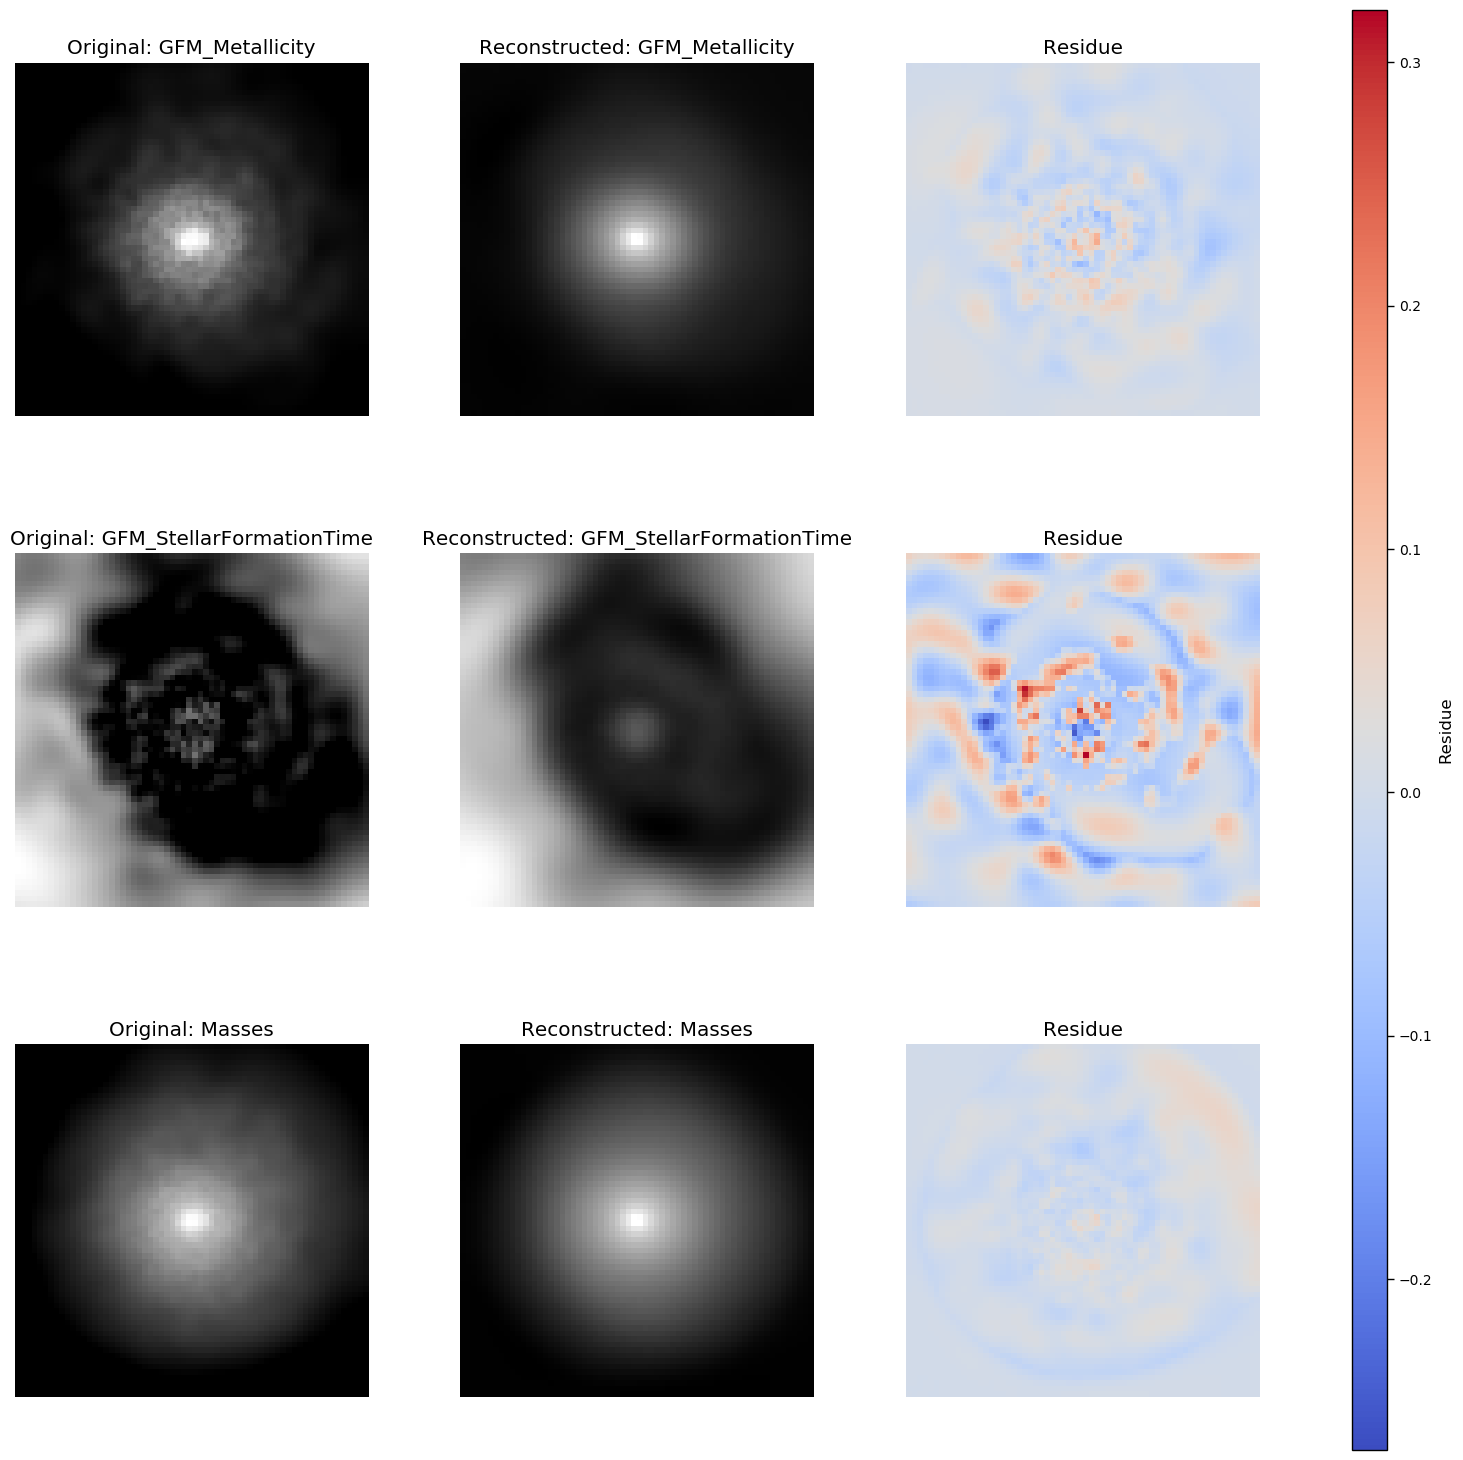

In [28]:
mm.compare(200)

In [59]:
n_zeros = []
for image in images:
    zeros = np.where(image == 0)
    n_zeros.append(len(zeros[0]))
    
n_zeros = np.array(n_zeros)
n_zeros.shape

(12484,)

In [80]:
len(np.where(images[3] == 0)[0])

1024

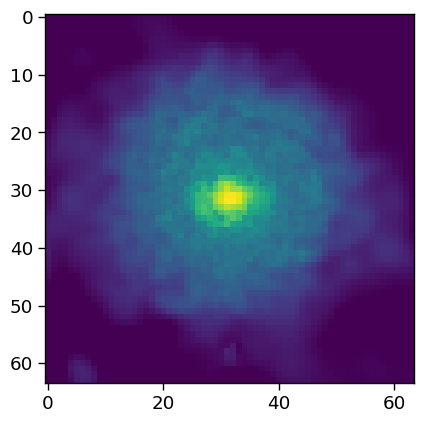

In [81]:
plt.imshow(images[3])

In [84]:
def diagonal_difference(image):
    center = 32
    differences = []

    for offset in range(10, center):
        # Current pixel value
        current_pixel = image[center-offset, center+offset]
        
        if offset == center-1:
            break
        # Next pixel value (one step diagonally)
        next_pixel = image[center-offset-1, center+offset+1]
    
        # Calculate difference and append
        differences.append(next_pixel - current_pixel)

    return np.array(differences)

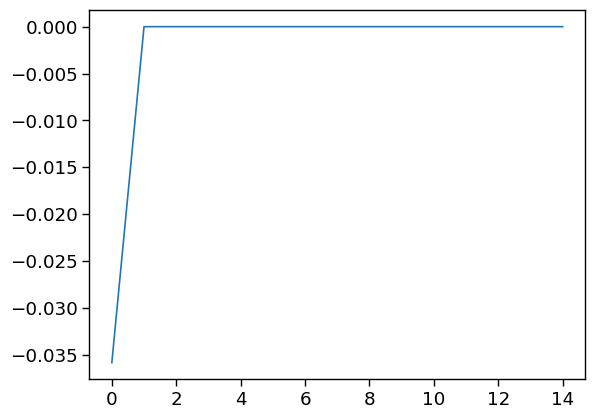

In [90]:
plt.plot(diagonal_difference(mm.datamatrix[2].reshape(3,64,64)[0]))

In [91]:
indx

array([ 3469,  2467,  6047, ..., 12256, 11922,  1917])

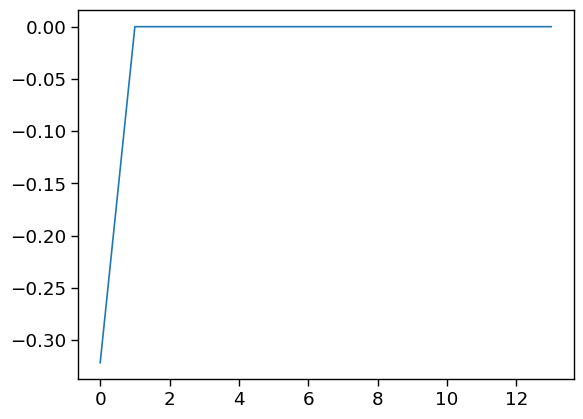

In [85]:
plt.plot(diagonal_difference(mm.datamatrix[indx[0]].reshape(3,64,64)[0]))

In [129]:
len(images)

11723

In [121]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import cv2 


# Generate a sample 64x64 galaxy image (replace this with your actual image)
galaxy_image = images[indx[1]]
galaxy_image = images[0]

def edge_detection(galaxy_image):
    # Define the Sobel operator kernels for edge detection
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Convolve the image with the Sobel kernels to find edges in the X and Y directions
    edges_x = convolve2d(galaxy_image, sobel_x, mode='same', boundary='wrap')
    edges_y = convolve2d(galaxy_image, sobel_y, mode='same', boundary='wrap')

    # Combine the X and Y edge maps to get the magnitude of the edges
    edge_magnitude = np.sqrt(edges_x**2 + edges_y**2)

    # Threshold the edge magnitude to get binary edges
    threshold = 0.8  # You can adjust this threshold value
    binary_edges = (edge_magnitude > threshold).astype(np.uint8)



    # Display the original image and the detected edges
    '''
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(galaxy_image, cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(binary_edges, cmap='gray')
    plt.title('Detected Edges')

    plt.show()

    '''


    # Find contours in the binary edge map
    contours, _ = cv2.findContours(binary_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the original image
    image_with_contours = np.copy(galaxy_image)

    # Filter and draw only the contours that enclose the galaxy
    surrounding_contours = []
    for contour in contours:
        if cv2.contourArea(contour) > 50:  # You can adjust the area threshold
            
            surrounding_contours.append(contour)
            cv2.drawContours(image_with_contours, [contour], -1, (0, 255, 0), 2)  # Draw the contour in green

    # Calculate the number of connected pixels surrounding the galaxy
    num_connected_pixels = sum([len(contour) for contour in surrounding_contours])
    return num_connected_pixels


# Display the image with detected contours
#plt.figure(figsize=(8, 8))
#plt.imshow(image_with_contours)
#plt.title(f'Detected Contours - {num_connected_pixels} Connected Pixels Surrounding Galaxy')
#plt.show()










In [122]:
connected_pixels = []

for image in images:
    connected_pixels.append(edge_detection(image))
    
connected_pixels = np.array(connected_pixels)
connected_pixels.shape

(12484,)

(array([9.998e+03, 2.000e+00, 6.700e+01, 4.960e+02, 5.120e+02, 3.850e+02,
        2.950e+02, 1.330e+02, 7.800e+01, 1.040e+02, 9.000e+01, 6.700e+01,
        6.300e+01, 4.200e+01, 2.300e+01, 1.600e+01, 1.800e+01, 1.500e+01,
        8.000e+00, 9.000e+00, 5.000e+00, 6.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 5.000e+00, 4.000e+00, 2.000e+00, 2.000e+00,
        5.000e+00, 5.000e+00, 3.000e+00, 4.000e+00, 4.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([  0. ,   4.3,   8.6,  12.9,  17.2,  21.5,  25.8,  30.1,  34.4,
         38.7,  43. ,  47.3,  51.6,  55.9,  60.2,  64.5,  68.8,  73.1,
         77.4,  81.7,  86. ,  90.3,  94.6,  98.9, 103.2, 107.5, 111.8,
        116.1, 120.4, 124.7, 129. , 133.3, 137.6, 141.9, 146.2, 150.5,
        154.8, 159.1, 163.4, 167.7, 172. , 176.3, 180.6, 184.9, 189.2,
        193.5, 197.8,

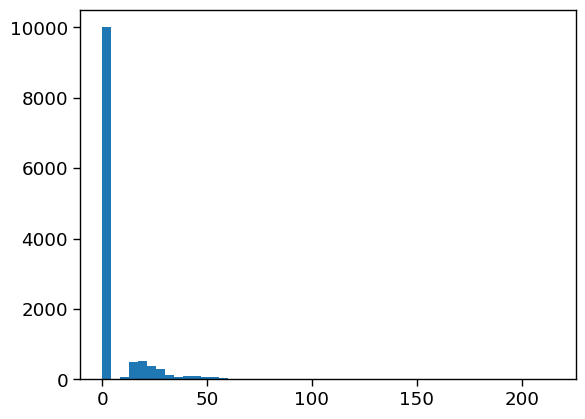

In [123]:
plt.hist(connected_pixels, bins = 50)

In [93]:
images = mm.datamatrix.reshape(-1,3,64,64)[:,0]

max_diff = []
for index in range(len(images)):
    diff = np.abs(diagonal_difference(mm.datamatrix[index].reshape(3,64,64)[0]))
    if len(diff) == 0:
        max_diff.append(0)
    else:
        diff = np.max(diff)
    max_diff.append(diff)
    
max_diff = np.array(max_diff)


/tmp/ipykernel_2892554/1680065999.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  max_diff = np.array(max_diff)


In [129]:
os.makedirs("outliers", exist_ok = True)
for index in outs:
    plt.imshow(images[index], cmap = "gray")
    plt.savefig(f"outliers/{index}.png")
    plt.close()
    


In [130]:
# zip images folder
import shutil
shutil.make_archive("outliers", 'zip', "outliers")

'/export/home/ucakir/MEGS/MEGS/src/outliers.zip'

In [24]:
from tqdm import tqdm 

In [25]:
import os 
os.makedirs("images", exist_ok = True)
for i, index in tqdm(enumerate(indx[:300])):
    plt.figure(figsize=(5,5))
    plt.imshow(mm.datamatrix[index].reshape(3,64,64)[0])
    plt.savefig(f"images/{i}_{index}.png")
    plt.close()
    
 

300it [00:32,  9.19it/s]


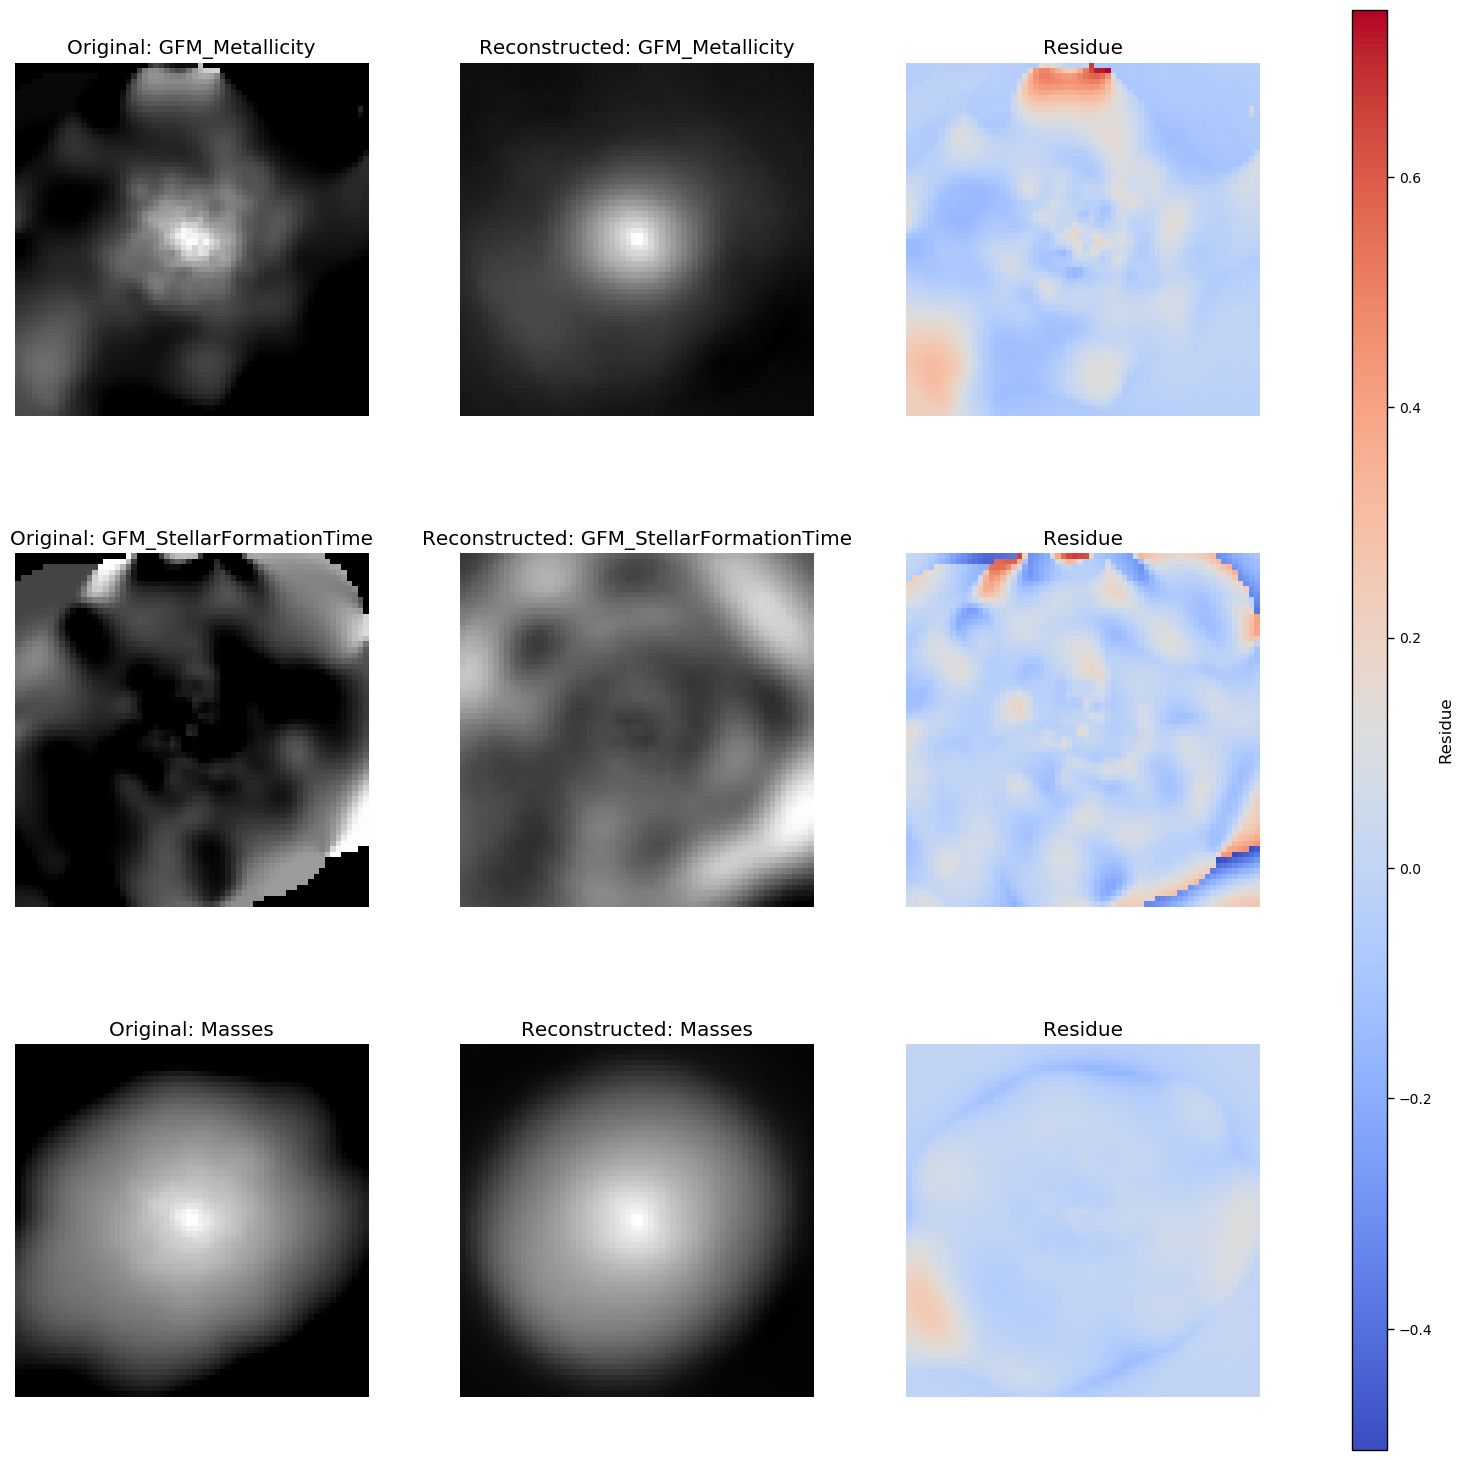

In [43]:
mm.compare(indx[210])

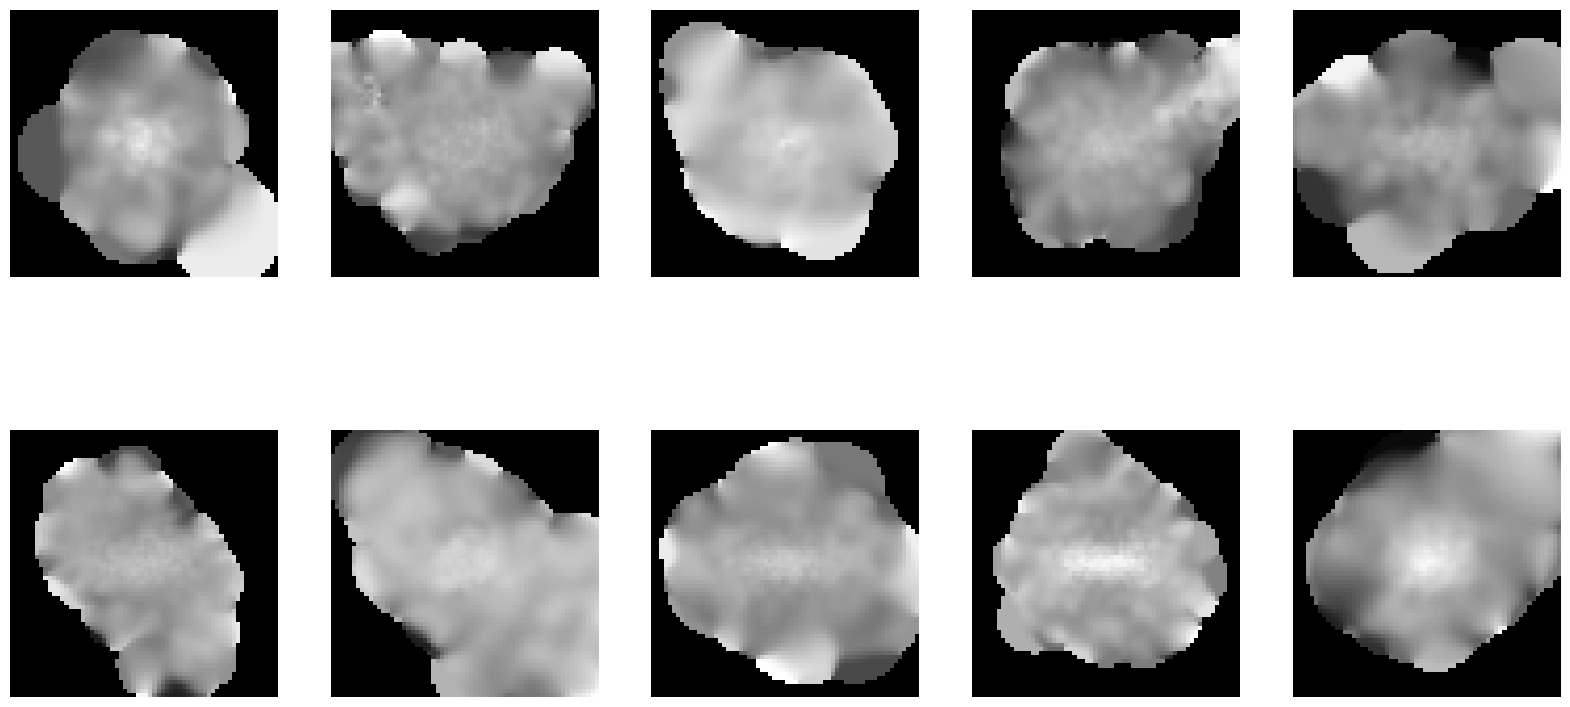

In [40]:
fig, ax = plt.subplots(2,5, figsize = (20,10))

for i in range(2):
    for j in range(5):
        ax[i,j].imshow(low_likelihood[i*5+j,0], cmap = "gray")
        ax[i,j].axis("off")
    

Text(0, 0.5, 'Umap 2')

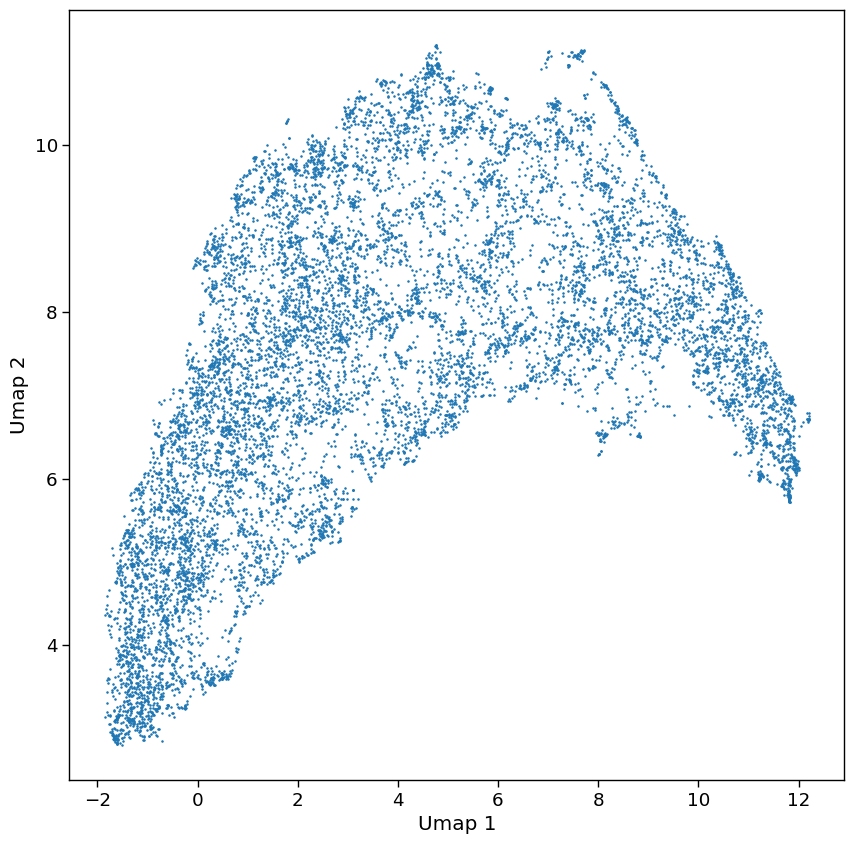

In [8]:
from umap import UMAP

umap = UMAP(n_components=2, n_neighbors=5, min_dist=0.001, metric='euclidean')
umap_embedding = umap.fit_transform(mm.scores)


# Plot the embedding
plt.figure(figsize=(10,10))
plt.scatter(umap_embedding[:,0], umap_embedding[:,1], s=1)
plt.xlabel("Umap 1")
plt.ylabel("Umap 2")


In [134]:
out_ind = np.where(umap_embedding[:,0] < 2)[0]
out_ind.shape

(129,)

In [137]:
out_in = np.where(umap_embedding[:,0]> 13)[0]
out_in.shape

(73,)

In [142]:
index = np.concatenate((out_ind, out_in))
index.shape

(202,)

In [144]:
halo_ids = data.get_attribute("halo_id")
outlier_ids = halo_ids[index]
np.save("outlier_ids.npy", outlier_ids)

In [139]:
outlier_index = np.concatenate(out_ind,out_in)

TypeError: only integer scalar arrays can be converted to a scalar index

In [140]:
outlier_index

NameError: name 'outlier_index' is not defined